In [1]:
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Activation, Dropout, Add, Attention
from keras import Sequential
from keras.layers import BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
import os
import numpy as np
import argparse
import pandas as pd
import math
from keras.layers import Conv1D, Flatten, Input,MaxPooling1D, SeparableConv1D, Attention
from tensorflow.keras import optimizers, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
!python --version

Python 3.10.12


In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive/Biomarketers
%pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kvysfPHz20qIMQi4u95yq6zZglZXtTs_/Biomarketers


'/content/drive/.shortcut-targets-by-id/1kvysfPHz20qIMQi4u95yq6zZglZXtTs_/Biomarketers'

In [ ]:
# First dataset :
X_train = pd.read_csv("X_train_final_30.csv", index_col=0)
print(X_train.shape)
y_train = pd.read_csv("y_train_30.csv")
# Storing the indices :
indices = y_train["Unnamed: 0"]
y_train = pd.read_csv("y_train_30.csv", index_col=0)
print(y_train.shape)
print(indices)



##CNN

In [4]:
model = Sequential()

model.add(Conv1D (kernel_size = 3, filters = 78, input_shape=(1533,1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.5))

model.add(Conv1D (kernel_size = 2, filters = 100))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size =2))


model.add(Conv1D(kernel_size =2, filters = 128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size =2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))
model.compile( loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1531, 78)          312       
                                                                 
 activation (Activation)     (None, 1531, 78)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 765, 78)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 765, 78)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 764, 100)          15700     
                                                                 
 activation_1 (Activation)   (None, 764, 100)          0         
                                                        

In [5]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto', restore_best_weights=True)  # Stop training after 5 epochs of no improvement in validation loss
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',  # Metric to be monitored
#                               factor=0.5,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
#                               patience=10,          # Number of epochs with no improvement after which learning rate will be reduced
#                               min_lr=1e-7,         # Lower bound on the learning rate
#                               verbose=1)
model_train = model.fit(X_train, y_train, batch_size=100,epochs=40,verbose=1, validation_split=0.2, callbacks=[early_stopping]) #


Epoch 1/40
21/21 [==============================] - 20s 854ms/step - loss: 1.3869 - accuracy: 0.5186 - val_loss: 0.6930 - val_accuracy: 0.4648
Epoch 2/40
21/21 [==============================] - 31s 2s/step - loss: 0.7351 - accuracy: 0.5871 - val_loss: 0.6919 - val_accuracy: 0.6971
Epoch 3/40
21/21 [==============================] - 28s 1s/step - loss: 0.6511 - accuracy: 0.6343 - val_loss: 0.6907 - val_accuracy: 0.7181
Epoch 4/40
21/21 [==============================] - 17s 815ms/step - loss: 0.6185 - accuracy: 0.6681 - val_loss: 0.6884 - val_accuracy: 0.7257
Epoch 5/40
21/21 [==============================] - 25s 1s/step - loss: 0.5964 - accuracy: 0.6948 - val_loss: 0.6841 - val_accuracy: 0.7810
Epoch 6/40
21/21 [==============================] - 23s 1s/step - loss: 0.5661 - accuracy: 0.7133 - val_loss: 0.6801 - val_accuracy: 0.7695
Epoch 7/40
21/21 [==============================] - 18s 852ms/step - loss: 0.5628 - accuracy: 0.7214 - val_loss: 0.6774 - val_accuracy: 0.7752
Epoch 8/40


In [ ]:
from keras.utils import plot_model
import pydot
# Générer le plot du modèle au format SVG
plot_model(model, to_file='Figures/model_CNN.png', show_shapes=True, show_layer_names=True, rankdir='TB',dpi=1000)

Output hidden; open in https://colab.research.google.com to view.

36/36 [==============================] - 0s 8ms/step
[[346 163]
 [ 79 538]]
Accuracy:0.79


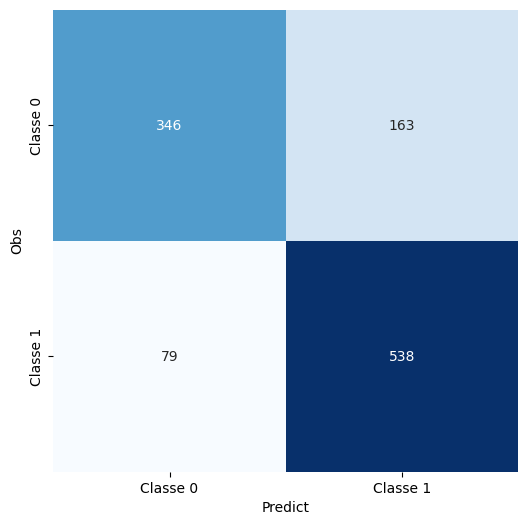

In [7]:
# perfs sur le test:

X_test = pd.read_csv("X_test_final_30.csv", index_col=0)
y_test = pd.read_csv("y_test_30.csv")
indices_test = y_test["Unnamed: 0"]
y_test = pd.read_csv("y_test_30.csv", index_col=0)
y_pred_test_proba = model.predict(X_test)
y_test_classes = np.where(y_pred_test_proba >= 0.5,1,0)
epsilon = 1e-5  # Small value to prevent log(0) errors
y_pred_test_proba = np.clip(y_pred_test_proba,epsilon, 1-epsilon)
y_test = y_test.values
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_test_classes)
print(cm)
tot = cm[0][0]+cm[1][1] + cm[0][1]+cm[1][0]
accuracy = (cm[0][0]+cm[1][1]) /tot
print(f"Accuracy:{accuracy:.2f}")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predict')
plt.ylabel('Obs')
plt.savefig('Figures/CNN_79_conf_matr.png',  dpi=500)
plt.show()
predictions = [1 if p>=0.5 else 0 for p in y_pred_test_proba]
# SAVE LES 0/1 PREDITS
y_pred_to_save = pd.DataFrame( predictions, indices_test)
y_pred_to_save.to_csv("YPred_models/y_pred_CNN_79.csv")
# SAVE LES PROBAS PREDITS
y_pred_prob_to_save = pd.DataFrame( y_pred_test_proba, indices_test)
y_pred_prob_to_save.to_csv("YPred_models/y_pred_prob_CNN_79.csv")

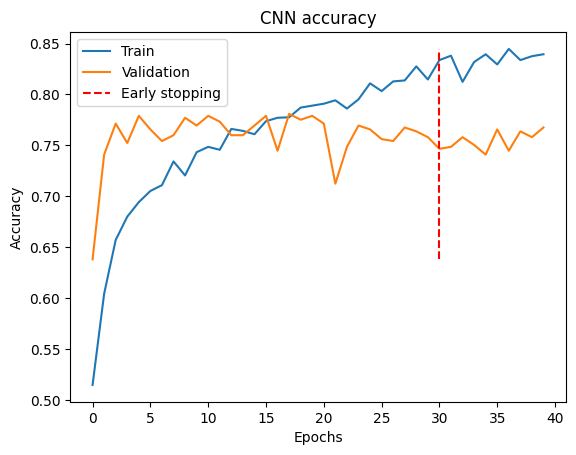

In [8]:
# Curves Accuracy
plt.plot(model_train.history['accuracy'])
plt.plot(model_train.history['val_accuracy'])
plt.vlines(x=30, ymin=min(model_train.history['val_accuracy']), ymax=max(model_train.history['accuracy']), colors='red', linestyles='dashed', label='Early stopping')
plt.title('CNN accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation', 'Early stopping'], loc='upper left')
plt.savefig('Figures/CNN_79_acc.png',  dpi=500)
plt.show()


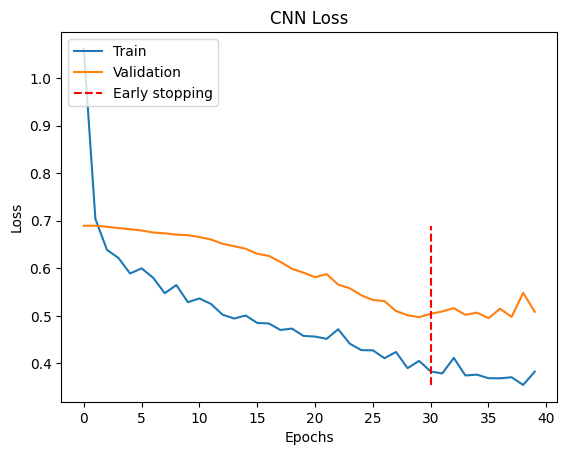

In [9]:
# Curves loss
plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.vlines(x=30, ymin=min(model_train.history['loss']), ymax=max(model_train.history['val_loss']), colors='red', linestyles='dashed', label='Early stopping')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation', 'Early stopping'], loc='upper left')
plt.savefig('Figures/CNN_79_loss.png',  dpi=500)
plt.show()


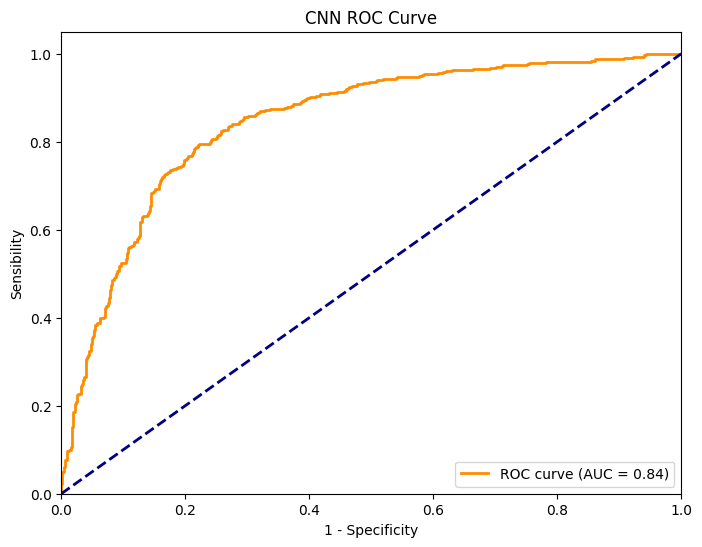

In [15]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensibility')
plt.title('CNN ROC Curve')
plt.legend(loc='lower right')
plt.savefig('Figures/CNN_79_ROC.png',  dpi=500)
plt.show()

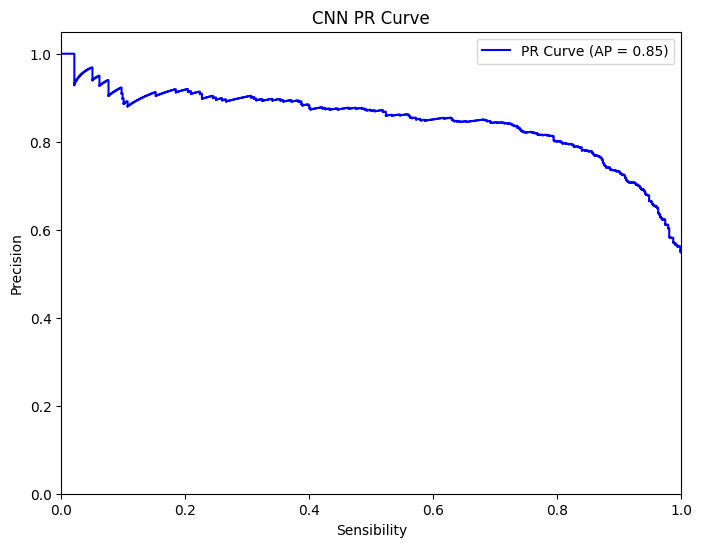

In [16]:
# PR curve :
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_test_proba)

average_precision = average_precision_score(y_test, y_pred_test_proba)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Sensibility')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('CNN PR Curve')
plt.legend(loc='upper right')
plt.savefig('Figures/CNN_79_PR.png',  dpi=500)
plt.show()

In [17]:
# Calculate F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_classes)
print("F1-Score:", f1)

F1-Score: 0.8082736674622116


In [18]:
# MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_test_classes)
print("MCC:", mcc)

MCC: 0.5667318548145499


In [19]:
# Sensibilité :
from sklearn.metrics import recall_score
sensitivity = recall_score(y_test, y_test_classes)

print("Sensibilité", sensitivity)

Sensibilité 0.8233387358184765


In [20]:
# Calculate Specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Specificity:", specificity)

Specificity: 0.7406679764243614


In [21]:
# Performances à soumettre sur le test de kaggle :
from sklearn.preprocessing import MinMaxScaler

X_test_Kaggle = pd.read_csv("test.csv")
print(X_test_Kaggle.shape)
scaler = MinMaxScaler()

# Fit and transform the data using Min-Max scaling
X_scaled = scaler.fit_transform(X_test_Kaggle)
print(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns = X_test_Kaggle.columns)# without the activity label
X_scaled = X_scaled[X_train.columns]
y_pred_test_proba = model.predict(X_scaled)
print(y_pred_test_proba.shape)

(2501, 1776)
[[0.37931035 0.61176451 0.05       ... 0.         1.         0.        ]
 [0.10344828 0.75817463 0.3        ... 0.         0.         0.        ]
 [0.10344828 0.65881212 0.1        ... 0.         0.         0.        ]
 ...
 [0.         0.53788699 0.15       ... 0.         0.         0.        ]
 [0.03444828 0.53850418 0.1        ... 0.         0.         0.        ]
 [0.17241379 0.64893183 0.05       ... 0.         0.         0.        ]]
79/79 [==============================] - 8s 98ms/step
(2501, 1)


In [22]:
# Créez un dictionnaire avec les données
y_pred_test_proba = y_pred_test_proba[:, 0]
data = {
    'MoleculeId': [i for i in range(1,2501+1 )],
    'PredictedProbability': y_pred_test_proba
}

# Créez un DataFrame à partir du dictionnaire
df = pd.DataFrame(data)

# Enregistrez le DataFrame au format CSV (ou tout autre format de votre choix)
df.to_csv('pred_CNN.csv', index=False)